# Power Outage Data Analysis

The goal of this ipython notebook is to determine what trends exist in the historical records of large power outages in the United States. I will do some exploratory data analysis and test out a few hypotheses about the nature of blackouts.





In [1]:
#import a number of useful modules
import pandas as pd
import numpy as np

import ssl
import datetime
import re

import statsmodels.api as sm
from sklearn import linear_model
from sklearn import tree
from sklearn.cross_validation import *
from sklearn import metrics
#from sklearn import svm
from sklearn import ensemble

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn 
%matplotlib inline
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

ssl._create_default_https_context = ssl._create_unverified_context #This is used to disable HTTPS certificate validation

## Blackout Data
By regulation, electric power utilities must report outages that disrupt more than 300MW or 50,000 customers and this data is made available by the U.S Department of Energy (DOE) through something called form OE-417. 
I will be analyzing data from the years 2002 till 2014.

In [2]:
data_14= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=62',skiprows=[0]) #row 0 useless info
data_13= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=41',skiprows=[0])
data_12= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=31', skiprows=[0])
data_11 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=22', skiprows=[0])
data_10 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=11',skiprows=[0])
data_09 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=10',skiprows=[0])
data_08 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=9',skiprows=[0,1])
data_07 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=8',skiprows=[0])
data_06 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=7',skiprows=[0])
data_05 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=6',skiprows=[0])
data_04= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=5',skiprows=[0])
data_03 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=4',skiprows=[0])
data_02 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=3',skiprows=[0,1])

WARNING *** file size (91844) not 512 + multiple of sector size (512)
WARNING *** file size (81604) not 512 + multiple of sector size (512)
WARNING *** file size (83140) not 512 + multiple of sector size (512)
WARNING *** file size (96964) not 512 + multiple of sector size (512)
WARNING *** file size (50884) not 512 + multiple of sector size (512)
WARNING *** file size (52420) not 512 + multiple of sector size (512)
WARNING *** file size (59587) not 512 + multiple of sector size (512)
WARNING *** file size (38595) not 512 + multiple of sector size (512)
WARNING *** file size (42179) not 512 + multiple of sector size (512)
WARNING *** file size (44227) not 512 + multiple of sector size (512)
WARNING *** file size (44227) not 512 + multiple of sector size (512)
WARNING *** file size (40131) not 512 + multiple of sector size (512)
WARNING *** file size (24259) not 512 + multiple of sector size (512)


### Quick note about the datasets
I took a quick glance through the data files and it appears that data from 2002 to 2010 have similarly named columns. Data from 2011 to 2014 have similarly named columns as well. Therefore, I will merge data from 2002 to 2010 (call this merge data_1). I will also merge data from 2011 to 2014 (call this merge data_2). 

I will spend some time cleaning the data in both merges. After I have achieved a clean/tidy dataset, I will proceed to do a final merge. 

However, before merging, I want to change the names of some of the columns to make things read/work easier.

In [3]:
data_02.rename(columns={'Area':'Area Affected'},inplace=True)
data_02.rename(columns={'Restoration Time':'Restoration'},inplace=True)
data_02.rename(columns={'Number of Customers Affected':'Number of Customers Affected 1'},inplace=True)
data_07.rename(columns={'Number of Customers Affected 1[1]':'Number of Customers Affected 1'},inplace=True)


### Merge the datasets. 
As mentioned earlier, I will perform two different merges using concat

In [4]:
data_1=pd.concat([data_02,data_03,data_04,data_05,data_06,data_07,data_08,data_09,data_10],ignore_index=True)
data_2=pd.concat([data_11,data_12,data_13,data_14],ignore_index=True)


Let's observe the shape (rows,columns) of the two datasets.

In [5]:
print "The shape of data_1:",data_1.shape
print "The shape of data_2:",data_2.shape

The shape of data_1: (1081, 8)
The shape of data_2: (959, 10)


#### Rename some columns in data_1

In [6]:
data_1.rename(columns={'Date': 'event_date'}, inplace=True)
data_1.rename(columns={'Time': 'event_time'}, inplace=True)
data_1.rename(columns={'Number of Customers Affected 1':'customers'},inplace=True)
data_1.rename(columns={'Type of Disturbance':'type'},inplace=True)
data_1.rename(columns={'Loss (megawatts)':'demand_loss'},inplace=True)
data_1.rename(columns={'Restoration':'restoration_date'},inplace=True)

#### Rename some columns in data_2

In [7]:
data_2.rename(columns= {'Date Event Began': 'event_date'}, inplace= True)
data_2.rename(columns= {'Time Event Began': 'event_time'}, inplace= True)
data_2.rename(columns= {'Respondent': 'utility'}, inplace= True)
data_2.rename(columns= {'Number of Customers Affected': 'customers'}, inplace= True)
data_2.rename(columns= {'Date of Restoration': 'restoration_date'}, inplace= True)
data_2.rename(columns= {'Demand Loss (MW)': 'demand_loss'}, inplace= True)
data_2.rename(columns= {'Event Type': 'type'}, inplace= True)
data_2.rename(columns= {'NERC Region': 'powerpool'}, inplace= True)

In [8]:
data_1.head(3) #see what the first 3 rows look like

,event_date,Utility/Power Pool (NERC Region),event_time,Area Affected,type,demand_loss,customers,restoration_date
0,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-30 00:00:00,Oklahoma Gas & Electric,06:00:00,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
2,NaN,(SPP),NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_2.head(3)

,event_date,event_time,restoration_date,Time of Restoration,utility,Area Affected,powerpool,type,demand_loss,customers
0,January,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-11 00:00:00,23:08:00,2011-01-11 00:00:00,23:08:00,New Athens Generating Co. LLC,"Athens, New York",NPCC,Electrical Fault at Generator,0,0
2,2011-01-12 00:00:00,06:00:00,2011-01-12 00:00:00,14:00:00,National Grid,Massachusetts,NPCC,Winter Storm,NaN,80000


#### check for missing values
A blackout report is associated with a utility. If a row does not contain information on the affected utility company, then that row is likely empty or doesn't contain useful information. 

In [10]:
print "Number of missing rows in utility column for data_1:",data_1['Utility/Power Pool (NERC Region)'].isnull().sum()
print "Number of missing rows in utility column for data_2:",data_2.utility.isnull().sum()


Number of missing rows in utility column for data_1: 232
Number of missing rows in utility column for data_2: 61


In [11]:
data_1=data_1.dropna(subset=['Utility/Power Pool (NERC Region)','event_date'])
data_2=data_2.dropna(subset=['utility','event_date']) 

Looking at data_1, the utility and nerc region information are lumped into one column. I need to split that column into two. 

First, I would like to get an idea of what type of values are in this column


In [12]:
np.sort(data_1['Utility/Power Pool (NERC Region)'].unique())

array([u'AEP West (SPP)', u'AES Cayuga (RFC)',
       u'AES Greenidge and Cayuga0RFC)',
       u'Alabama Electric Coop Inc.  (SERC)',
       u'Alabama Electric Cooperative (SERC)', u'Allegheny Power (MAAC)',
       u'Allegheny Power (RFC)', u'Allegheny Power (RFC, SERC)',
       u'Alliant Energy (MRO)', u'Ameren (SERC)',
       u'Ameren Corporation (MRO)', u'Ameren Corporation (SERC)',
       u'American Electric Company (RFC)',
       u'American Electric Power  (ECAR)',
       u'American Electric Power (CSWS) (SPP)',
       u'American Electric Power (ECAR)',
       u'American Electric Power (ERCOT)',
       u'American Electric Power (REC)', u'American Electric Power (RFC)',
       u'American Electric Power (SPP)', u'American Electric Power (TRE)',
       u'American Electric Power - CSWS (ECAR)',
       u'American Electric Power -AEP West (ECAR)',
       u'American Electric Power CSWS (SPP)',
       u'American Electric Power-Texas Central Company (ERCOT)',
       u'American Transmission

The nerc region is in parenthesis, hence I will split the strings in this column based on the left hand parenthesis. 

In [13]:
nerc = data_1['Utility/Power Pool (NERC Region)'].str.split('(',expand= True)
data_1['utility']=nerc[0]
data_1['powerpool']= nerc[1].str.replace(')','') #get rid of the right sided parenthesis

Check to see if meaningless rows exist and then delete 

In [14]:
np.sort(data_1.utility.unique())

array([u'AEP West ', u'AES Cayuga ', u'AES Greenidge and Cayuga0RFC)',
       u'Alabama Electric Coop Inc.  ', u'Alabama Electric Cooperative ',
       u'Allegheny Power ', u'Alliant Energy ', u'Ameren ',
       u'Ameren Corporation ', u'American Electric Company ',
       u'American Electric Power ', u'American Electric Power  ',
       u'American Electric Power - CSWS ',
       u'American Electric Power -AEP West ',
       u'American Electric Power CSWS ',
       u'American Electric Power-Texas Central Company ',
       u'American Transmission', u'American Transmission Company, LLC ',
       u'Arizona Public Service ', u'Arizona Public Service Company ',
       u'Arkansas Electric Cooperative Corporation ',
       u'Associated Electric Cooperative, Inc. ',
       u'Atlantic City Electric ', u'Atlantic City Electric  ',
       u'Austin Energy ', u'Baltimore Gas & Electric Company ',
       u'Baltimore Gas and Electric ',
       u'Baltimore Gas and Electric Company ',
       u'Big Rive

In [15]:
data_1['utility']=data_1.utility.str.strip() #remove white spaces from the left and right

There are a few noticeable meaningless values that I have observed from simply looking through the utility column. I will remove them from the sample

In [16]:
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Utility/Power Pool (NERC Region)']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences,  January through December 2005']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences,  January through December 2004']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences, 2003']
#I may still have some other meaningless rows after these changes. May have to look at the end to make sure
data_1.shape

(800, 10)

The next thing I need to do is parse the date variable. The date variable has some issues with certain observations that need to be corrected before the entire column is a datetime.datetime column

In [17]:
data_1.event_date.unique()

array([datetime.datetime(2002, 1, 30, 0, 0),
       datetime.datetime(2002, 1, 29, 0, 0),
       datetime.datetime(2002, 2, 27, 0, 0),
       datetime.datetime(2002, 3, 9, 0, 0),
       datetime.datetime(2002, 4, 8, 0, 0),
       datetime.datetime(2002, 7, 9, 0, 0),
       datetime.datetime(2002, 7, 19, 0, 0),
       datetime.datetime(2002, 7, 20, 0, 0),
       datetime.datetime(2002, 8, 2, 0, 0),
       datetime.datetime(2002, 8, 9, 0, 0),
       datetime.datetime(2002, 8, 25, 0, 0),
       datetime.datetime(2002, 8, 28, 0, 0),
       datetime.datetime(2002, 10, 3, 0, 0),
       datetime.datetime(2002, 11, 6, 0, 0),
       datetime.datetime(2002, 11, 17, 0, 0),
       datetime.datetime(2002, 12, 3, 0, 0),
       datetime.datetime(2002, 12, 11, 0, 0),
       datetime.datetime(2002, 12, 14, 0, 0),
       datetime.datetime(2002, 12, 19, 0, 0),
       datetime.datetime(2002, 12, 25, 0, 0),
       datetime.datetime(2003, 1, 25, 0, 0),
       datetime.datetime(2003, 2, 27, 0, 0),
       dat

A quick glance of this column shows a couple values that need to be adjusted. 

In [18]:
newIndex=range(0,len(data_1)) #create a new index
data_1['index']=newIndex
data_1=data_1.set_index('index')

Fix the individual date rows that have problems

In [19]:
date=[] #this empty list will hold the values

for i in range(len(data_1)):
    if data_1['event_date'].str.contains('7/01//05')[i]==True:
        date.append(datetime.datetime.strptime('7/01/2005','%m/%d/%Y'))
    elif data_1['event_date'].str.contains(u' 1/19/05')[i]==True:
        date.append(datetime.datetime.strptime(u'1/19/2005','%m/%d/%Y'))   
    else:
        date.append(data_1['event_date'][i])
data_1['event_date']=date    

        

Now I will move on to the restoration_date variable 

In [20]:
print "The number of missing data in restoration_date:", data_1.restoration_date.isnull().sum()

The number of missing data in restoration_date: 1


In [21]:
data_1.restoration_date.unique()

array([datetime.datetime(2002, 2, 7, 12, 0), nan,
       datetime.datetime(2002, 2, 10, 21, 0),
       datetime.datetime(2002, 2, 27, 11, 35),
       datetime.datetime(2002, 3, 11, 12, 0),
       datetime.datetime(2002, 4, 9, 0, 0),
       datetime.datetime(2002, 7, 9, 19, 54),
       datetime.datetime(2002, 7, 19, 16, 30),
       datetime.datetime(2002, 7, 20, 20, 12),
       datetime.datetime(2002, 8, 2, 18, 36),
       datetime.datetime(2002, 8, 9, 12, 13),
       datetime.datetime(2002, 8, 25, 9, 17),
       datetime.datetime(2002, 8, 28, 15, 38),
       datetime.datetime(2002, 10, 12, 0, 0), u'Noon November 10',
       u'Unknown', datetime.datetime(2002, 11, 21, 8, 0),
       datetime.datetime(2002, 12, 9, 22, 30),
       datetime.datetime(2002, 12, 13, 22, 0),
       datetime.datetime(2002, 12, 19, 16, 0),
       datetime.datetime(2002, 12, 21, 17, 0),
       datetime.datetime(2002, 12, 26, 5, 0),
       datetime.datetime(2002, 12, 27, 8, 30), u'1/26/03, 2:00 a.m.',
       u'3/01

In [22]:
data_1['event_year']= data_1['event_date'].dt.year

There are different formats that the individual rows in restoration_date column take. My solution is to force the rows to convert into datetime and then observe the rows that were not converted successfully. I can then make changes to those rows and then convert them to datetime.datetime.

In [23]:
data_1['rest_date']=pd.to_datetime(data_1['restoration_date'],errors='coerce') #coerce rows to be converted
data_1['rest_year']=data_1['event_year']
print "After parsing the rest_date, how many missing values are there?", data_1.rest_date.isnull().sum()


After parsing the rest_date, how many missing values are there? 22


Clearly parsing the dates through coercion led to missing values. Let's look at these rows and see why they didn't parse

In [24]:
data_1[data_1.rest_date.isnull()]


,event_date,Utility/Power Pool (NERC Region),event_time,Area Affected,type,demand_loss,customers,restoration_date,utility,powerpool,event_year,rest_date,rest_year
index,,,,,,,,,,,,,
1,2002-01-29,Kansas City Power & Light (SPP),Evening,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN,Kansas City Power & Light,SPP,2002,NaT,2002
14,2002-11-06,Pacific Gas & Electric Co. (WSCC),22:00:00,Northern and Central California,Winter Storm,270,939000,Noon November 10,Pacific Gas & Electric Co.,WSCC,2002,NaT,2002
15,2002-11-17,Long Island Power Authority (NPPC),15:48:00,"Northport, NY",Cable Tripped,0,0,Unknown,Long Island Power Authority,NPPC,2002,NaT,2002
28,2003-04-28,American Transmission,3:41 p.m.,"County of Waukesha, Wisconsin,",Vandalism,0,0,"4/29/03, 12:00 noon",American Transmission,None,2003,NaT,2003
29,2003-05-02,Duke Energy Company/,5:00 p.m.,"Piedmont, North and",Severe Thunderstorms,1500,139000,"5/04/03, 12:00 noon",Duke Energy Company/,None,2003,NaT,2003
47,2003-08-14,Midwest Independent System Operator (ECAR),Approximately 3:00 p.m.,Geographic areas for MISO Reliability Coordina...,Unknown *,"Approx. 18,500 MW, in MISO area:",NaN,Approximately,Midwest Independent System Operator,ECAR,2003,NaT,2003
54,2003-08-14,"PJM Interconnection, LLC (MAAC)",4:10 p.m.,"Northern New Jersey Erie, Pennsylvania area",Unknown *,"4,100 MW (Northern NJ) and 400 MW, (Erie, PA)...",NaN,Approximately,"PJM Interconnection, LLC",MAAC,2003,NaT,2003
56,2003-08-26,Baltimore Gas and Electric (MAAC),4:00 p.m.,"Maryland: Anne Arundel County, Baltimore Count...",Severe Thunderstorms,625,"93,000 at peak 133,000 cumulative","8/29/03, 12:00 noon",Baltimore Gas and Electric,MAAC,2003,NaT,2003
60,2003-09-18,Carolina Power and Light (SERC),11:45 a.m.,Eastern North Carolina,Hurricane Isabel,peak 1655,"peak 320,00 9/18/03 7:00 p.m.","9/18/03, 12:00 midnight",Carolina Power and Light,SERC,2003,NaT,2003


Some of these rows have noon or midnight in them. I can easily replace them with p.m and a.m. respectively. 

In [25]:

rest=[]
for i in range(len(data_1)): 
    if data_1.restoration_date.str.contains('12:00 midnight')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12:00 midnight','12:00 a.m.')[i])
    elif data_1['restoration_date'].str.contains('12:00 noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12:00 noon','12:00 p.m.')[i])
    elif data_1['restoration_date'].str.contains('Noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('Noon','12:00 p.m.')[i]) 
    elif data_1['restoration_date'].str.contains('12 noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12 noon','12:00 p.m.')[i])
    elif data_1['restoration_date'].str.contains('9/08/05,12:01 a.m.')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('9/08/05,12:01 a.m.','9/08/05, 12:01 a.m.')[i])
    elif data_1['restoration_date'].str.contains('10/18/05, 3: 37 p.m.')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('10/18/05, 3: 37 p.m.','10/18/05, 3:37 p.m.')[i])
    else:
        rest.append(data_1['restoration_date'][i])
data_1['rest_date']=rest


In [26]:
data_1['rest_date']=pd.to_datetime(data_1.rest_date,errors='coerce')


After correcting the issues, the only rows that did not convert are those labeled ongoing or unknown (A total of 12 rows out of 800 rows).

While converting the dates, some rows ended up with year 2016 because the year wasn't explicity accounted for in the dataset. These dates need to be changed to the actual dates. 

I also have to account for cases(those with year 2016) where the blackout happens at the end of the year(december) and recovery is completed at the beginning of the next year

In [27]:
rest_datetime=[]
for i in range(len(data_1)): 
    if data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]<12:
        rest_datetime.append(data_1['rest_date'][i].replace(year = data_1['event_year'][i]))
    elif data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]==12 and data_1['rest_date'].dt.month[i]==1:
        rest_datetime.append(data_1['rest_date'][i].replace(year=data_1['event_year'][i] + 1 ))
    elif data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]==12 and data_1['rest_date'].dt.month[i]==12:
        rest_datetime.append(data_1['rest_date'][i].replace(year=data_1['event_year'][i]))
    else:
        rest_datetime.append(data_1['rest_date'][i])
data_1['restoration_datetime']=rest_datetime

In [28]:
data_1['blackout_duration']=data_1.restoration_datetime-data_1.event_date #this is how long it took to restore power fully


Let's look at data_2 (2011 to 2014) and clean it up as well.

In [29]:
data_2.event_date.unique()

array([datetime.datetime(2011, 1, 11, 0, 0),
       datetime.datetime(2011, 1, 12, 0, 0),
       datetime.datetime(2011, 1, 13, 0, 0),
       datetime.datetime(2011, 1, 18, 0, 0),
       datetime.datetime(2011, 1, 23, 0, 0),
       datetime.datetime(2011, 1, 24, 0, 0),
       datetime.datetime(2011, 1, 25, 0, 0),
       datetime.datetime(2011, 1, 26, 0, 0),
       datetime.datetime(2011, 1, 27, 0, 0),
       datetime.datetime(2011, 1, 31, 0, 0),
       datetime.datetime(2011, 2, 1, 0, 0),
       datetime.datetime(2011, 2, 2, 0, 0),
       datetime.datetime(2011, 2, 3, 0, 0),
       datetime.datetime(2011, 2, 9, 0, 0),
       datetime.datetime(2011, 2, 10, 0, 0),
       datetime.datetime(2011, 2, 17, 0, 0),
       datetime.datetime(2011, 2, 19, 0, 0),
       datetime.datetime(2011, 2, 20, 0, 0),
       datetime.datetime(2011, 2, 24, 0, 0),
       datetime.datetime(2011, 2, 25, 0, 0),
       datetime.datetime(2011, 3, 1, 0, 0),
       datetime.datetime(2011, 3, 6, 0, 0),
       datetime.

In [30]:
data_2=data_2[data_2.event_date != 'Date Event Began']

In [31]:
data_2.loc[:,'event_date']=pd.to_datetime(data_2.event_date)

In [32]:
data_2.restoration_date.isnull().sum()

0

In [33]:
data_2.restoration_date.unique()

array([datetime.datetime(2011, 1, 11, 0, 0),
       datetime.datetime(2011, 1, 12, 0, 0),
       datetime.datetime(2011, 1, 13, 0, 0),
       datetime.datetime(2011, 1, 18, 0, 0),
       datetime.datetime(2011, 1, 23, 0, 0),
       datetime.datetime(2011, 1, 24, 0, 0),
       datetime.datetime(2011, 1, 25, 0, 0),
       datetime.datetime(2011, 1, 27, 0, 0),
       datetime.datetime(2011, 1, 31, 0, 0),
       datetime.datetime(2011, 1, 29, 0, 0),
       datetime.datetime(2011, 1, 30, 0, 0),
       datetime.datetime(2011, 2, 3, 0, 0),
       datetime.datetime(2011, 2, 2, 0, 0),
       datetime.datetime(2011, 2, 4, 0, 0),
       datetime.datetime(2011, 2, 9, 0, 0),
       datetime.datetime(2011, 2, 10, 0, 0),
       datetime.datetime(2011, 2, 19, 0, 0),
       datetime.datetime(2011, 2, 23, 0, 0),
       datetime.datetime(2011, 2, 20, 0, 0),
       datetime.datetime(2011, 2, 24, 0, 0),
       datetime.datetime(2011, 2, 25, 0, 0),
       datetime.datetime(2011, 2, 27, 0, 0),
       datetim

In [34]:
data_2.restoration_date=pd.to_datetime(data_2['restoration_date'],errors='coerce')

In [35]:
np.sort(data_2.restoration_date.dt.year.unique() )

array([ 2001.,  2011.,  2012.,  2013.,  2014.,  2015.,  2077.,    nan])

Because the dataset is from 2011 to 2014, it is very obvious that the values 2001 and 2077 have no place in the data. 2015 could occur if the blackout happended late in 2014 and recovery wasn't concluded untill 2015

In [36]:
#create a new_index
#newIndex_2=range(len(data_2))
#data_2.loc[:,'index']=newIndex_2 
data_2=data_2.reset_index()


In [37]:
#replace 2077 and 2001 with 2011
restoration_date=[]
for i in range(len(data_2)):
    if data_2['restoration_date'].dt.year[i]==2077 or data_2['restoration_date'].dt.year[i]==2001:
        restoration_date.append(data_2.restoration_date[i].replace(year=2011))
    else:
        restoration_date.append(data_2.restoration_date[i])
data_2['restoration_date']=restoration_date

In [38]:
data_2['blackout_duration'] = data_2.restoration_date-data_2.event_date

### Merge both data sets

In [39]:
data=pd.concat([data_1,data_2],ignore_index=True)

In [40]:
data.shape

(1691, 17)

In [41]:
data['OutageDays']=data.blackout_duration.astype('timedelta64[D]') #This is the number of days without power

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 18 columns):
Area Affected                       1691 non-null object
Time of Restoration                 891 non-null object
Utility/Power Pool (NERC Region)    800 non-null object
blackout_duration                   1654 non-null timedelta64[ns]
customers                           1482 non-null object
demand_loss                         1303 non-null object
event_date                          1691 non-null datetime64[ns]
event_time                          1690 non-null object
event_year                          800 non-null float64
index                               891 non-null float64
powerpool                           1665 non-null object
rest_date                           788 non-null datetime64[ns]
rest_year                           800 non-null float64
restoration_date                    1665 non-null object
restoration_datetime                788 non-null datetime64[ns]
type     

In [43]:
data.head()

,Area Affected,Time of Restoration,Utility/Power Pool (NERC Region),blackout_duration,customers,demand_loss,event_date,event_time,event_year,index,powerpool,rest_date,rest_year,restoration_date,restoration_datetime,type,utility,OutageDays
0,Oklahoma,NaN,Oklahoma Gas & Electric,8 days 12:00:00,1881134,500,2002-01-30,06:00:00,2002.0,NaN,None,2002-02-07 12:00:00,2002.0,2002-02-07 12:00:00,2002-02-07 12:00:00,Ice Storm,Oklahoma Gas & Electric,8.0
1,Metropolitan Kansas City Area,NaN,Kansas City Power & Light (SPP),NaT,270000,500-600,2002-01-29,Evening,2002.0,NaN,SPP,NaT,2002.0,NaN,NaT,Ice Storm,Kansas City Power & Light,NaN
2,Missouri,NaN,Missouri Public Service (SPP),11 days 21:00:00,95000,210,2002-01-30,16:00:00,2002.0,NaN,SPP,2002-02-10 21:00:00,2002.0,2002-02-10 21:00:00,2002-02-10 21:00:00,Ice Storm,Missouri Public Service,11.0
3,California,NaN,San Diego Gas & Electric (WSCC),0 days 11:35:00,255000,300,2002-02-27,10:48:00,2002.0,NaN,WSCC,2002-02-27 11:35:00,2002.0,2002-02-27 11:35:00,2002-02-27 11:35:00,Interruption of Firm Load,San Diego Gas & Electric,0.0
4,Lower Peninsula of Michigan,NaN,Consumers Energy Co. (ECAR),2 days 12:00:00,190000,190,2002-03-09,00:00:00,2002.0,NaN,ECAR,2002-03-11 12:00:00,2002.0,2002-03-11 12:00:00,2002-03-11 12:00:00,Severe Weather,Consumers Energy Co.,2.0


Handle customer column

In [44]:
data.customers.unique()

array([1881134, 270000, 95000, 255000, 190000, 0, u'1 PG&E', 63500, 53565,
       25000, 242910, 939000, 224912, 43000, 130000, u'1.5 million',
       385000, 106000, 95630, nan, u'over 340,000', 425000, 160000, 68530,
       139000, u'102,842 (Georgia)', 192000, 2, 179299, 47000, 1, 52000,
       131000, 55142, 72000, 134500, 80000, 108000, 185000, 90000, 2100000,
       101000, 1203000, u'unknown', 840137, 3125350,
       u'93,000 at peak 133,000 cumulative', 153000, u'4 (industrial)',
       u'1.8 million', u'peak 320,00 9/18/03 7:00 p.m.', 650000, 237366,
       u'Under 50,000', u'Over 530,000 peak on 9/19/03',
       u'108,000 (Dist. And Trans. Combined)', 245000, 51000, 110000,
       50280, u'104,195 at 5:23 p.m. 11/13/03', 67000, 300000,
       u'200,000 (Peak)', u'6 (utilities)', 36000, 16500, 120000, 109750,
       241000, 263000, 145000, 18600, 150000, 30689, 9905,
       u'Approx. 70,000', 87456, u' PG&E', 505000, 47165, 63000, 206000,
       u'Approx. 100,000', u'85,000 at

In [45]:
data['customers']=data.customers.replace(',','',regex=True)

In [46]:
data.customers.unique()

array([1881134, 270000, 95000, 255000, 190000, 0, u'1 PG&E', 63500, 53565,
       25000, 242910, 939000, 224912, 43000, 130000, u'1.5 million',
       385000, 106000, 95630, nan, u'over 340000', 425000, 160000, 68530,
       139000, u'102842 (Georgia)', 192000, 2, 179299, 47000, 1, 52000,
       131000, 55142, 72000, 134500, 80000, 108000, 185000, 90000, 2100000,
       101000, 1203000, u'unknown', 840137, 3125350,
       u'93000 at peak 133000 cumulative', 153000, u'4 (industrial)',
       u'1.8 million', u'peak 32000 9/18/03 7:00 p.m.', 650000, 237366,
       u'Under 50000', u'Over 530000 peak on 9/19/03',
       u'108000 (Dist. And Trans. Combined)', 245000, 51000, 110000, 50280,
       u'104195 at 5:23 p.m. 11/13/03', 67000, 300000, u'200000 (Peak)',
       u'6 (utilities)', 36000, 16500, 120000, 109750, 241000, 263000,
       145000, 18600, 150000, 30689, 9905, u'Approx. 70000', 87456,
       u' PG&E', 505000, 47165, 63000, 206000, u'Approx. 100000',
       u'85000 at peak', 17900

In [47]:
data['customers']=data.customers.replace('[.]','',regex=True)

In [48]:
data['customers']=data['customers'].replace(r'.million','00000',regex=True) #convert the million

My solution for cleaning this column is to create two new columns. The first column I create by coercing the rows of the customer column into numeric. Rows with non-numeric become NaN. 

However, I will create a second column where I extract and put the numeric values from rows that also contain non-numeric.

In [49]:
data['cust']=pd.to_numeric(data.customers, errors='coerce')

In [50]:
data['customer_1']=data.customers.str.extract('(\d+)', expand=True) 

In [51]:
data.customer_1=pd.to_numeric(data['customer_1'],errors='coerce')

customers=[]
for i in range(len(data)):
    if data['customer_1'].notnull()[i]:
        customers.append(data['customer_1'][i])
    else:
        customers.append(data['cust'][i])
data['customers']=customers

### Handle the demand loss column

In [52]:
data.demand_loss.unique()

array([500, u'500-600', 210, 300, 190, 0, 240, 278, 232, 51, 120, 67.6,
       nan, 270, 63, 180, 56, 250, 1000, u'200-250', 212, 1500, 130, 476,
       200, 150, u'75-90 ', 80, 11000, u'230-300', u'500-1000', 440,
       u'Approx. 18,500 MW, in MISO area:', 1007, 7000, 2500, 22934,
       u'4,100 MW (Northern NJ) and 400 MW, (Erie,  PA) area', 11202, 625,
       310, 6512, u'peak 1655 ', 2000, 3085, u'500-700', 1300, 350,
       u'Est. 371.1', u'Est. 75', 375, u'Approx. 180', u'Est. 400', 630,
       175, 650, 27, 14, 220, 160, 170, 100, u'Less than 150', 475,
       u'Approx. 300', 60, u'Approx. 30  ', 10, u'Less than 300',
       u'Approx. 100', 662, u'Approx. 85',
       u'133 on 5/21/04  between 3:00 a.m. and 4:00  a.m., 392 on 5/21/04 between 4:00 p.m. and 5:00 p.m.',
       u'177 on 5/21/04 between 3:00 p.m. and 5:00 p.m.', u'60 at peak, ',
       303, 1900, 280, 428, 157, 50, u'-', 283, 600, 214, u'Approx. 200',
       61, 127, 480, 451.7, 1400, 700, 65, 22700, 450, 125, 6000, 

Remove the strings from rows that also have numbers.

In [53]:
data['lost_power']=data.demand_loss #create a copy of demand_loss variable to avoid losing info

In [54]:
data['lost_power']=data['lost_power'].replace(',','',regex=True)

In [55]:
data['lost_power']=data.lost_power.str.extract('(\d+)', expand=True) 

In [56]:
data['lost_power']=pd.to_numeric(data['lost_power'],errors='coerce')
data['demand']=pd.to_numeric(data['demand_loss'],errors='coerce')
loss=[]
for i in range(len(data)):
    if data['lost_power'].notnull()[i]:
        loss.append(data['lost_power'][i])
    else:
        loss.append(data['demand'][i])
    #elif data['rub'][i] == np.nan:
        #new_rub.append(data['demand_loss'][i])

In [57]:
data['loss']=loss


In [122]:
data[data.loss.isnull()].demand_loss.value_counts()

Unknown                269
UNK                     83
-                       20
--                       2
All                      1
None                     1
unknown                  1
2011-06-08 00:00:00      1
UNK                      1
  N/A                    1
Name: demand_loss, dtype: int64

Now the dataset is ready for analysis. I will create a new dataset that only contains the essential columns

In [58]:
important_variables=['utility','event_date','powerpool','loss','customers','type','OutageDays','Area Affected']

In [59]:
df=data[important_variables]

In [60]:
df.head()

,utility,event_date,powerpool,loss,customers,type,OutageDays,Area Affected
0,Oklahoma Gas & Electric,2002-01-30,None,500.0,1881134.0,Ice Storm,8.0,Oklahoma
1,Kansas City Power & Light,2002-01-29,SPP,500.0,270000.0,Ice Storm,NaN,Metropolitan Kansas City Area
2,Missouri Public Service,2002-01-30,SPP,210.0,95000.0,Ice Storm,11.0,Missouri
3,San Diego Gas & Electric,2002-02-27,WSCC,300.0,255000.0,Interruption of Firm Load,0.0,California
4,Consumers Energy Co.,2002-03-09,ECAR,190.0,190000.0,Severe Weather,2.0,Lower Peninsula of Michigan


In [62]:
df.loc[:,'type'] = df.type.str.lower()

create a variable that indicates what caused the blackout

In [63]:
cause=[]
for i in range(len(df)):
    if df['type'].str.contains('hurricane')[i]==True:
        cause.append('Hurricane')
    elif df['type'].str.contains('thunder')[i] ==True:
        cause.append('Thunderstorm')
    elif df['type'].str.contains('shed')[i] ==True:
        cause.append('Load Shedding')
    elif df['type'].str.contains('earthquake')[i] ==True:
        cause.append('Earthquake')
    elif df['type'].str.contains('vandal')[i] or df['type'].str.contains('attack')[i] or df['type'].str.contains('sabotage')[i] ==True:
        cause.append('Intentional Attack')
    elif df['type'].str.contains('fuel supply')[i]==True:
        cause.append('Fuel Issues')
    elif df['type'].str.contains('equipment malfunction')[i] or df['type'].str.contains('failure')[i]==True:
        cause.append('Equipment Failure')
    elif df['type'].str.contains('tornado')[i]==True:
        cause.append('Tornadoes')
    elif df['type'].str.contains('voltage reduct')[i]==True:
        cause.append('Voltage Reduction')
    elif df['type'].str.contains('public appeal')[i]==True:
        cause.append('Public Appeal')
    elif df['type'].str.contains('severe weather')[i]==True:
        cause.append('Severe Weather')
    elif df['type'].str.contains('islanding')[i]==True:
        cause.append('Islanding')
    elif df['type'].str.contains('lightning')[i]==True:
        cause.append('Lightning')
    elif df['type'].str.contains('snow')[i] or df['type'].str.contains('winter')[i] or df['type'].str.contains('ice')[i]==True:
        cause.append('Snow')
    elif df['type'].str.contains('wind')[i]==True:
        cause.append('Wind')
    elif df['type'].str.contains('firm power')[i] or df['type'].str.contains('firm load')[i]==True:
        cause.append('Firm power interruption')
    else:
        cause.append('Others')

df['cause']=cause


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


I will drop events that are caused by voltage reduction as these events generally do not lead to disrupted electricity service

In [64]:
df=df[df.cause !='Voltage Reduction']

### create blackout size category 

In [118]:
loss_group=[]
for row in df['loss']:
    if row>=0 and row<=299:
        loss_group.append('1-299')
    elif row>=300 and row<=999:
        loss_group.append('300-999')
    elif row>=1000 and row<=2999:
        loss_group.append('1000-2999')
    elif row>=3000 and row<=9999:
        loss_group.append('3000-9999')
    elif row>=10000 and row <=29999:
        loss_group.append('10000-29999')
    elif row>=30000:
        loss_group.append('>=30000')
    else:
        loss_group.append('unknown')
df['loss_group']=loss_group

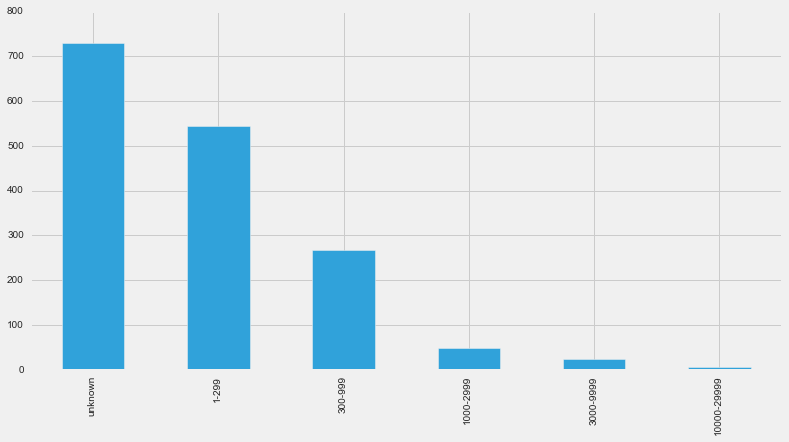

In [119]:
df['loss_group'].value_counts().plot(kind='bar')

In [120]:
df[df.loss_group=='>=30000']

,utility,event_date,powerpool,loss,customers,type,OutageDays,Area Affected,cause,month,year,loss_group


## Summary
In the preceding steps, I did the following:
1. Converted Strings to numbers in situations where I could
2. Fixed date variables
3. I removed from the dataset blackouts caused by voltage reduction
4. Dropped extraneous features


## Exploratory Data Analysis
Let's look closer at the data

In [66]:
df[['loss','customers','OutageDays']].describe()

,loss,customers,OutageDays
count,903.000000,1.223000e+03,1623.000000
mean,574.008859,1.641888e+05,1.894640
std,1778.944044,3.382216e+05,5.095692
min,0.000000,0.000000e+00,-1.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,22934.000000,4.645572e+06,131.000000


There are a number of missing data points from the loss and customers. This is expected given that many of these values are denoted as 'unknown' or 'NA' in the dataset. 

Later on, I will consider data imputation methods for missing data

Looking at the descriptive statistics, two things stand out: the max amount of power lost is 22,934MW. This seems like a lot for one blackout. In addition, we also have a maximum of 131 outage days, which is very long.

I would like to look at this particular data point and also observe data for blackouts longer than 30 days.

In [67]:
df[df.OutageDays>=30]

,utility,event_date,powerpool,loss,customers,type,OutageDays,Area Affected,cause
32,We Energies,2003-05-15,None,240.0,2.0,flood,32.0,Upper Michigan Peninsula,Others
122,Salt River Project,2004-07-06,WECC,NaN,NaN,fire/substation multiple public appeals,34.0,"Metro Phoenix, Arizona",Public Appeal
123,Arizona Public Service,2004-07-06,WECC,NaN,NaN,fire/substation multiple public appeals,34.0,"Metro Phoenix, Arizona",Public Appeal
613,"New Covert Generating Company, LLC",2009-03-03,RFC,378.0,NaN,transformer faulted/unit tripped,54.0,Southwest Michigan,Others
1380,ITC Transmission,2013-06-21,MRO,NaN,NaN,suspected cyber attack,131.0,"Michigan, Iowa",Intentional Attack
1514,We Energies,2014-01-24,RFC,NaN,NaN,fuel supply emergency - coal,75.0,Wisconsin,Fuel Issues
1533,"Somerset Operating Company, LLC",2014-02-07,NPCC,675.0,NaN,fuel supply emergency - coal,42.0,Niagara County New York,Fuel Issues


It seems very unlikely that customers would be without power for more than a month except in rare cases involving natural disasters. These values may be as a result of incorrect data entries. Until further investigation, I will drop OutageDays greater than 50days(note that this is a somewhat arbitrary selection)

In [68]:
df=df[df.OutageDays<=50]

### Distribution of blackouts by cause

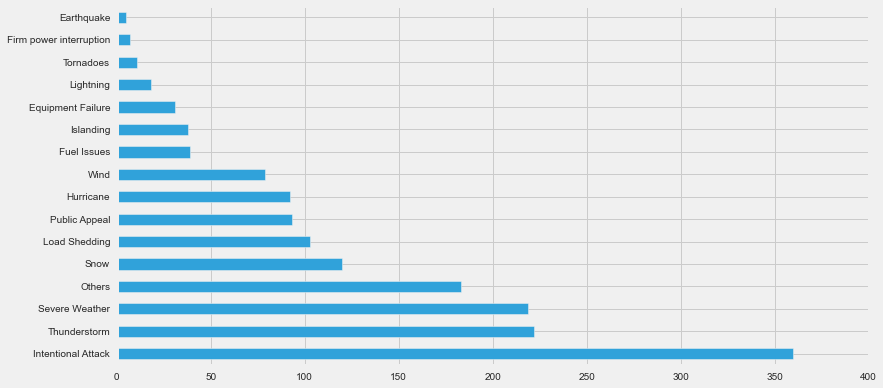

In [69]:
df.cause.value_counts().plot(kind='barh')

Intentional attacks and vandalism is the most common cause of blackouts reported in the sample between 2002 and 2014. This could mean that the electric grid system is very vulnerable to cyber attacks and intentional vandalism. 

Perhaps, more investment is needed to combat this. 

### Distribution of blackouts by year and month

In [70]:
df['month']=df.event_date.dt.month #create a month variable

In [71]:
df['year']=df.event_date.dt.year #create a year variable

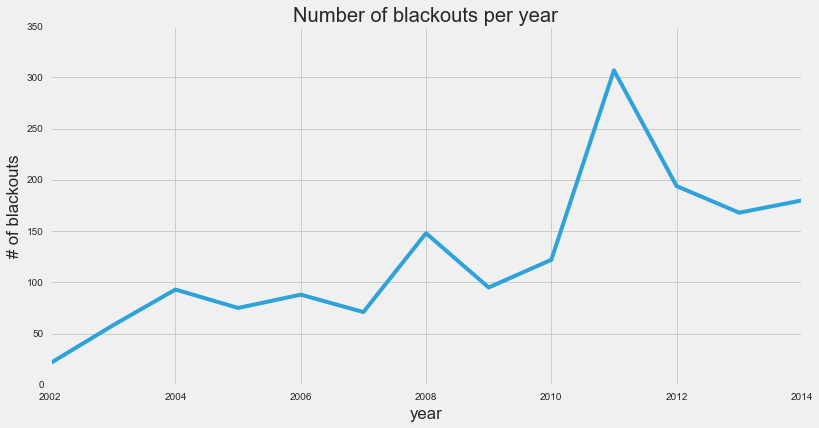

In [73]:
df.year.value_counts(sort=False).plot()
plt.ylabel('# of blackouts')
plt.xlabel('year')
plt.title('Number of blackouts per year')

It seems like the number of blackouts reported by utilities is steadily increasing till it reaches its peak in 2011. This is interesting because it may imply that the electricity grid system is getting worse over the years in terms of how it is dealing with blackouts. However, it could also be due to more improved and mandatory reporting of blackouts of different types.

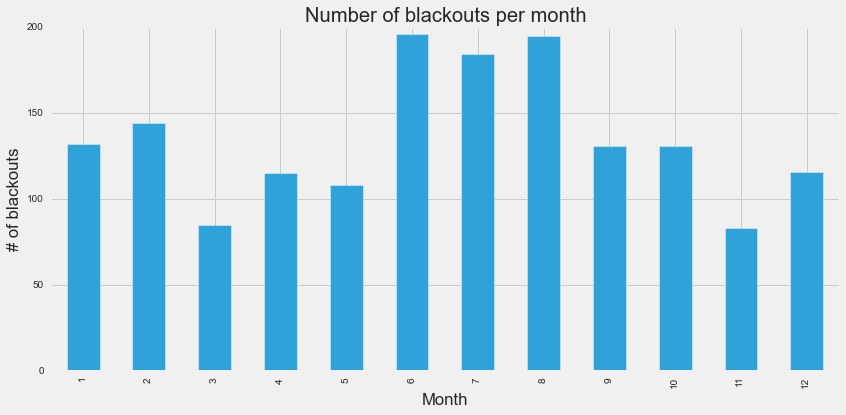

In [74]:

df.month.value_counts(sort=False).plot(kind='bar')

plt.ylabel('# of blackouts')
plt.xlabel('Month')
plt.title('Number of blackouts per month')
plt.tight_layout()

We observe that most of the blackouts reported by utilities occur during the summer months between June and August. One reason for this is likely that hot summer days leads to an increase in usage of air conditioning systems, which further put stress on the grid. 

### Group by the cause of blackout
Now lets categorize what causes each blackout

In [75]:
cause_group=df.groupby('cause')


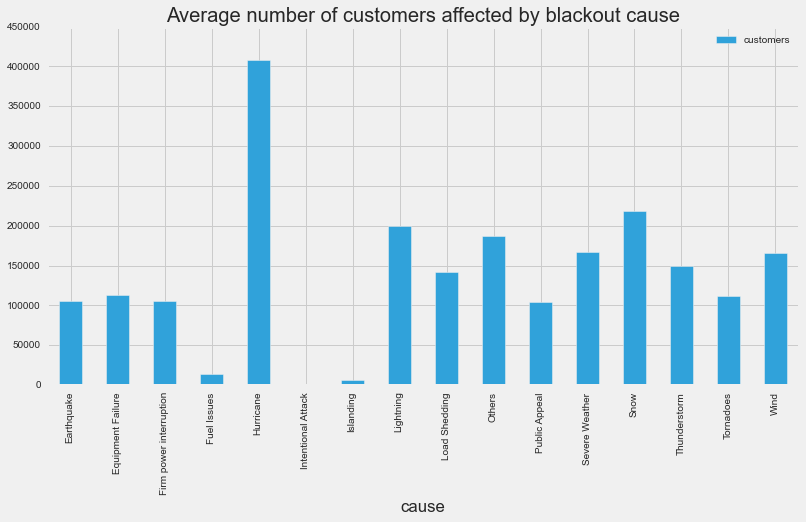

In [77]:
cause_group[['customers']].mean().plot(kind='bar')
#plt.ylabel('Average number of customers')
plt.title('Average number of customers affected by blackout cause')

On average, hurricanes affect more customers than anyother cause of blackout

(0, 3000000)

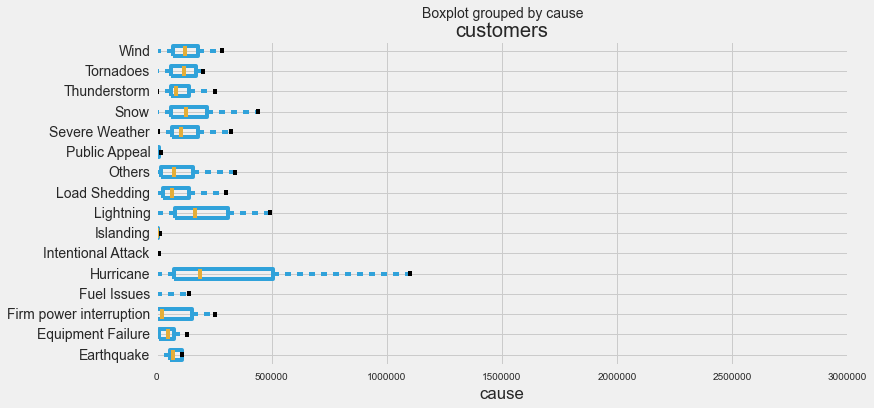

In [98]:
df.boxplot('customers',by='cause',vert=False)
plt.xlim(0,3000000)


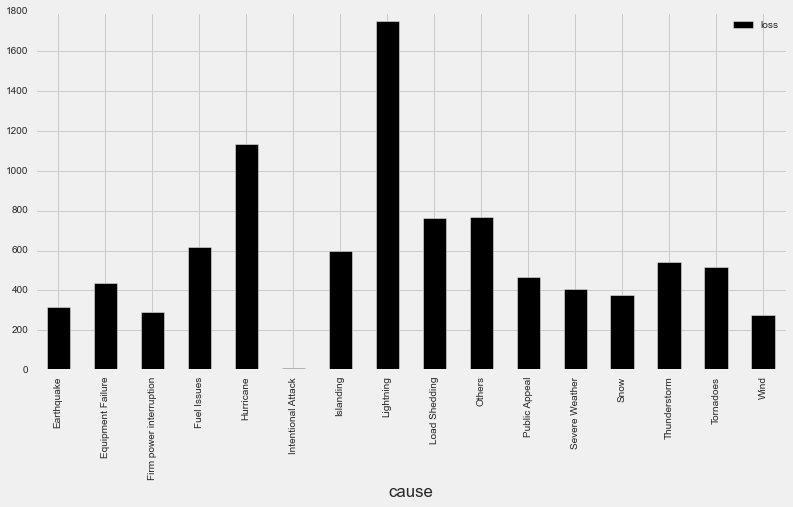

In [86]:
cause_group[['loss']].mean().plot(kind='bar',color='k')

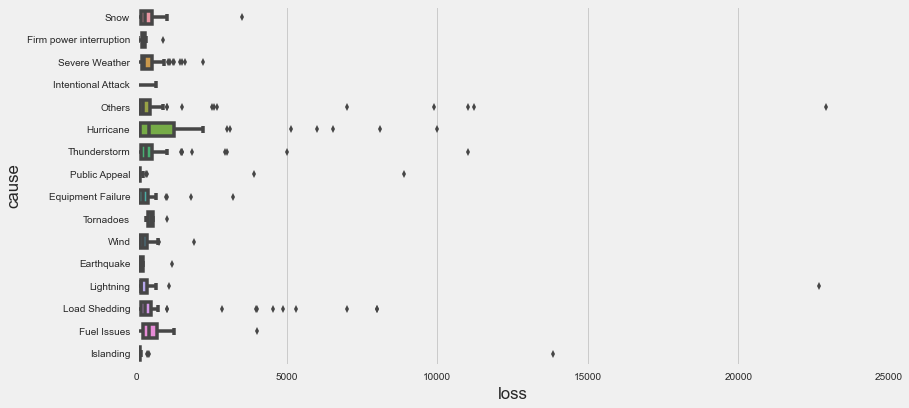

In [96]:
seaborn.boxplot(y=df['cause'],x=df['loss'],linewidth=3.5,width=0.6)

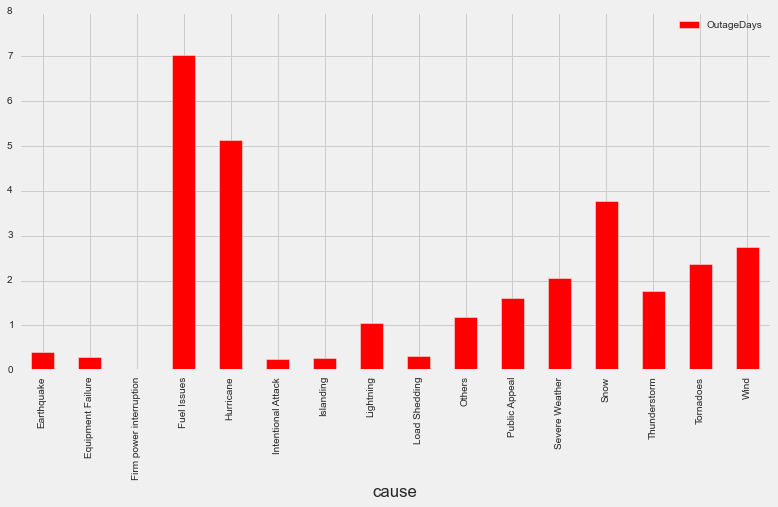

In [99]:
cause_group[['OutageDays']].mean().plot(kind='bar',color='r')

In [131]:
cause_group[['OutageDays']].describe().unstack()

OutageDays                                            \
                             count      mean       std  min  25%  50%    75%   
cause                                                                          
Earthquake                     5.0  0.400000  0.547723  0.0  0.0  0.0   1.00   
Equipment Failure             31.0  0.290323  0.528744  0.0  0.0  0.0   0.50   
Firm power interruption        7.0  0.000000  0.000000  0.0  0.0  0.0   0.00   
Fuel Issues                   39.0  7.025641  8.919190  0.0  1.0  3.0  12.50   
Hurricane                     92.0  5.130435  4.704960  0.0  1.0  4.0   8.00   
Intentional Attack           360.0  0.250000  0.989499 -1.0  0.0  0.0   0.00   
Islanding                     38.0  0.263158  0.828030  0.0  0.0  0.0   0.00   
Lightning                     18.0  1.055556  2.013841  0.0  0.0  0.0   1.00   
Load Shedding                103.0  0.320388  1.733259 -1.0  0.0  0.0   0.00   
Others                       183.0  1.185792  2.938643  0.0  0.0  0.0   1.00   
Public Appeal                 93.0  1.612903  5.017431  0.0  0.0  0.0   2.00   
Severe Weather               219.0  2.063927  1.966584  0.0  1.0  2.0   3.00   
Snow                         120.0  3.775000  3.366824  0.0  1.0  2.5   5.25   
Thunderstorm                 222.0  1.761261  1.696879  0.0  1.0  1.0   2.00   
Tornadoes                     11.0  2.363636  1.858641  0.0  1.0  3.0   3.00   
Wind                          79.0  2.746835  3.196426  0.0  0.5  2.0   4.00   

                               
                          max  
cause                          
Earthquake                1.0  
Equipment Failure         2.0  
Firm power interruption   0.0  
Fuel Issues              42.0  
Hurricane                19.0  
Intentional Attack       15.0  
Islanding                 4.0  
Lightning                 6.0  
Load Shedding            17.0  
Others                   32.0  
Public Appeal            34.0  
Severe Weather            9.0  
Snow                     16.0  
Thunderstorm              8.0  
Tornadoes                 6.0  
Wind                     17.0

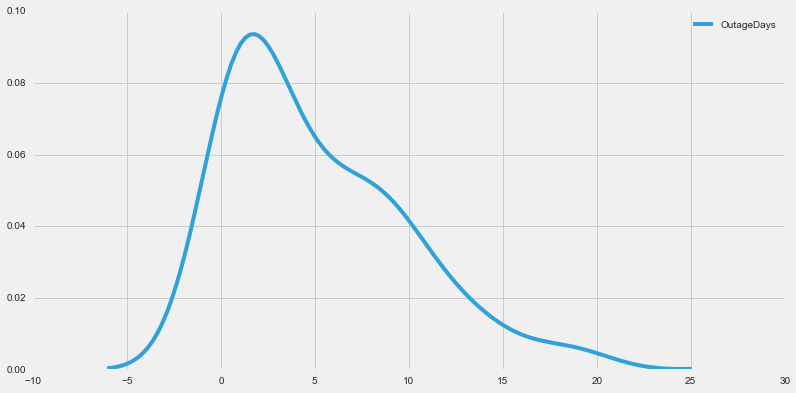

In [135]:
seaborn.kdeplot(df[df.cause=='Hurricane'].OutageDays)

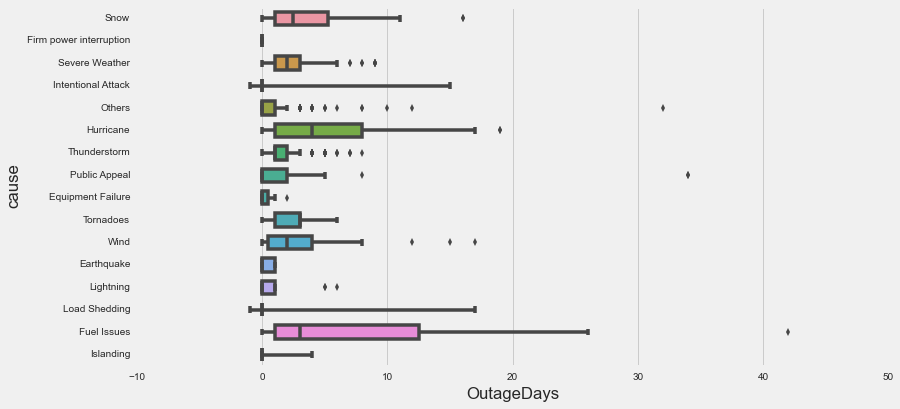

In [103]:
seaborn.boxplot(y=df['cause'],x=df['OutageDays'],linewidth=3.5,width=0.6)

### Correlation 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11573bed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116978150>]], dtype=object)

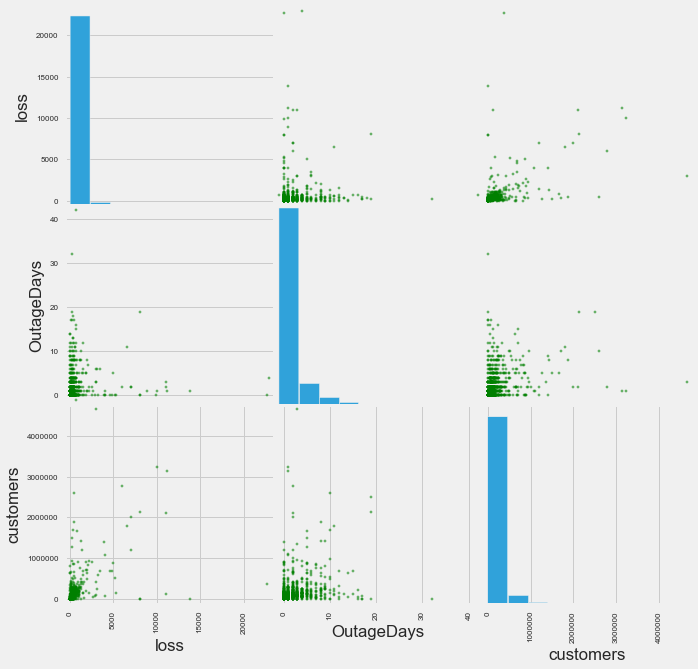

In [101]:
pd.tools.plotting.scatter_matrix(df[['loss','OutageDays','customers']],figsize=(10,10),color='g')


In [102]:
df_cor=df[['OutageDays','customers','loss']].corr()
df_cor


,OutageDays,customers,loss
OutageDays,1.000000,0.267093,0.063901
customers,0.267093,1.000000,0.484546
loss,0.063901,0.484546,1.000000


Looking at the entire sample, it appears that there's little correlation between the variables. The number of affected customers and loss have the highest correlation.

What would probably be more interesting would be to take a closer look based on the cause of the blackout

### The distribution of days without power

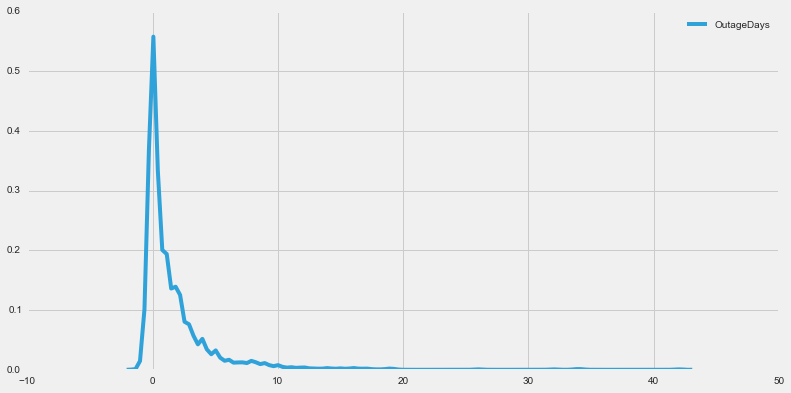

In [105]:
seaborn.kdeplot(df.OutageDays)

### Relationship between the blackout size and the number of days without power

It seems reasonable that a large blackout will require a long time for power to be restored. The size of the blackout is measured in MW(this is the loss column) and OutageDays is the number of days without power.

In [106]:
df.loss.corr(df.OutageDays)

0.063900573148409467

In [110]:
cause_group_cor=cause_group[['OutageDays','loss']].corr()

 # below main lower triangle of an array
cause_group_cor= cause_group_cor.stack()
cause_group_cor[(cause_group_cor > 0.45) | (cause_group_cor < -0.45)]


cause                                          
Earthquake               OutageDays  OutageDays    1.000000
                                     loss          0.593641
                         loss        OutageDays    0.593641
                                     loss          1.000000
Equipment Failure        OutageDays  OutageDays    1.000000
                         loss        loss          1.000000
Firm power interruption  loss        loss          1.000000
Fuel Issues              OutageDays  OutageDays    1.000000
                         loss        loss          1.000000
Hurricane                OutageDays  OutageDays    1.000000
                         loss        loss          1.000000
Intentional Attack       OutageDays  OutageDays    1.000000
                         loss        loss          1.000000
Islanding                OutageDays  OutageDays    1.000000
                         loss        loss          1.000000
Lightning                OutageDays  OutageDays    1

In [108]:
len(df[df.cause=='Earthquake'])

5

In [109]:
len(df[df.cause=='Tornadoes'])

11

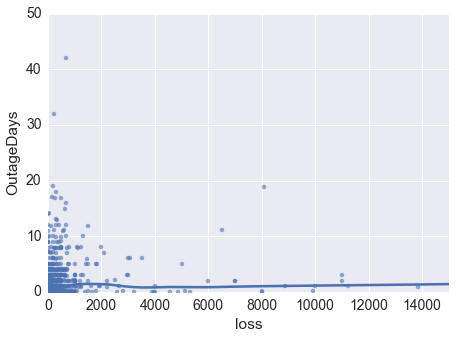

In [128]:
seaborn.set(font_scale=1.4, rc={"lines.linewidth": 1.7}) 
#greater_zero=blackout_data.query('OutageDays>0')
g = seaborn.lmplot("loss", "OutageDays", x_jitter= .5,  y_jitter= .1,
           data=df,lowess=True, size=5,aspect=1.4, legend_out=False,
           scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(0, 15000),ylim=(0, 50))

#g.savefig('1.png',transparent=True)



In [129]:
df.customers.corr(df.OutageDays)

0.26709334351077835

Loss in MW as a measure of blackout size shows no correlation with the number of days without power. The number of customers without power also shows a weak correlation with the number of days without power

## Next steps
1. Answer some interesting questions using Machine learning models: For instance, can we predict how long it would take to restore power after a blackout?